In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import rgb2hex
import matplotlib
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_recall_curve, PrecisionRecallDisplay

# Set LaTeX, commet if undesired
matplotlib.rcParams.update({
    'text.usetex' : True,
    'text.latex.preamble' : r'\usepackage[spanish,es-tabla]{babel}\decimalpoint\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}'
})

from utils import read_image, color_list
from utils.loading import data_generator

from enum import Enum
import os

cm2inch = lambda x: 0.393701*x


2024-05-10 11:28:16.111479: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-10 11:28:17.385744: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Model

Pre-trained VGG16unet model is loaded: trained for 50 epochs at a resolution 224x224. The model is under `models/VGG16unet-224x224-50epochs.model.keras`. If you don't have this model it is publicly availabe at [kaggle](https://www.kaggle.com/models/sergiogarciapajares/vggcloudunet/).

In [2]:
model = tf.keras.models.load_model(os.path.join('models','VGG16unet-224x224-50epochs.model.keras'))

2024-05-10 11:28:21.386350: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Some general constants about image shape are provided by the model itself

In [3]:
IMG_SHAPE = model.input[0].shape[1:] #model.input returns a single element list with the actual input layer
IMG_WIDTH  = IMG_SHAPE[0]
IMG_HEIGHT = IMG_SHAPE[1]
IMG_CHANNELS = IMG_SHAPE[2]

NUM_CLASSES = model.output[0].shape[3] # model.output returns a single element list with the actual output layer

# Test dataset

In [4]:
test_image_names = open(os.path.join('dataset','test.txt')).readlines()
test_dataset = data_generator(
    [os.path.join('dataset','images', name.strip()) for name in test_image_names],
    [os.path.join('dataset','masks', name.strip()) for name in test_image_names],
    batch_size = 2, # test dataset contains 46 images, 46 = 23·2, to include all images 2 must be picked (as 23 is too high)
    num_classes=NUM_CLASSES,
    img_shape=IMG_SHAPE,
)
print(test_dataset)

# Segment day and night images
isNIGHT = [5,6,13,14,26,36,37,43,44]
isDay = np.ones(len(test_image_names),dtype=bool)
isDay[isNIGHT] = False

<_BatchDataset element_spec=(TensorSpec(shape=(2, 224, 224, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(2, 224, 224, 5), dtype=tf.float32, name=None))>


We can predict on out testing dataset. `predictions_prob` contains the one-hot enconded probabilities for each label. `predictions` contains the final predicted label. `ground_truth` contains real labels. 

In [5]:
try: #try cached file first
    predictions = np.load(os.path.join('graficosTFG','predictions.npy'))
except FileNotFoundError: # Run model
    predictions_prob = model.predict(test_dataset)
    predictions = np.argmax(predictions_prob,axis=-1)
    np.save(predictions, os.path.join('graficosTFG','predictions.npy') )

In [6]:
ground_truth = np.empty_like(predictions)
for index, name in enumerate(test_image_names):
    ground_truth[index,:,:] = read_image( os.path.join('dataset','masks', name.strip()) , IMG_SHAPE )[:,:,0]

# Metrics

## Pixel accuracy

The number of right prediction $\text{Acuracy}=\dfrac{\text{TP}}{\text{Total}}$

In [7]:
np.sum(ground_truth==predictions)/np.prod(ground_truth.shape)


0.9340300403449423

If we do it per label [`N/A`,`sky`,`sun`,`thick`,`thin`]

In [8]:
label_acuracy = np.empty(NUM_CLASSES,dtype=np.float32)
for label in range(NUM_CLASSES):
    label_acuracy[label] = np.sum( (ground_truth == predictions)[ ground_truth == label ])/np.sum( ground_truth == label )

label_acuracy

array([0.98757994, 0.9209399 , 0.84710354, 0.91881067, 0.00099561],
      dtype=float32)

It's pretty good at finding `N/A`, `sky` and `thick`. But it misses the rest.

## Confusion matrix

In [9]:
def PlotConfusionMatrix(y_pred:np.ndarray,y_true:np.ndarray) -> None:

    plt.figure(figsize=(5.9,4))
    ConfusionMatrixDisplay(
        confusion_matrix(
            y_pred=y_pred.flatten(),
            y_true=y_true.flatten(),
            labels=np.arange(NUM_CLASSES),
            normalize = 'true',
        )*100
    ).plot(
        values_format='.1f',
        im_kw={
            'vmax' :100,
            'vmin' :  0,
        }
    )

    ax = plt.gca()
    ax.set_xlabel('Etiquetas inferidas')
    ax.set_ylabel('Etiquetas manuales')
    ax.set_xticks(np.arange(NUM_CLASSES),['N/A','Cielo','Sol','Espesa','Fina'])
    ax.set_yticks(np.arange(NUM_CLASSES),['N/A','Cielo','Sol','Nube\nespesa','Nube\nfina'])
    # ax.set_title('Matriz de confusión')

    cbar = ax.images[-1].colorbar
    cbar.set_ticks(
        ticks = list(range(0,101,20)),
        labels = [f"{percent} \%" for percent in range(0,101,20)],
        )

    plt.tight_layout(pad=.1)

### All

<Figure size 590x400 with 0 Axes>

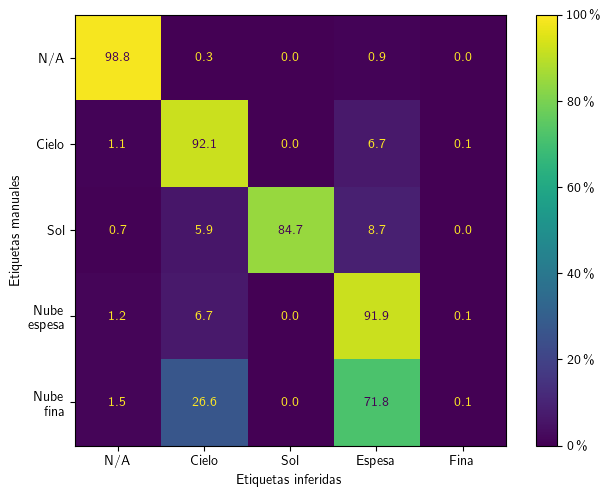

In [10]:
PlotConfusionMatrix(predictions,ground_truth)
plt.savefig('graficosTFG/ConfusionMatrix.pdf')

### Night

<Figure size 590x400 with 0 Axes>

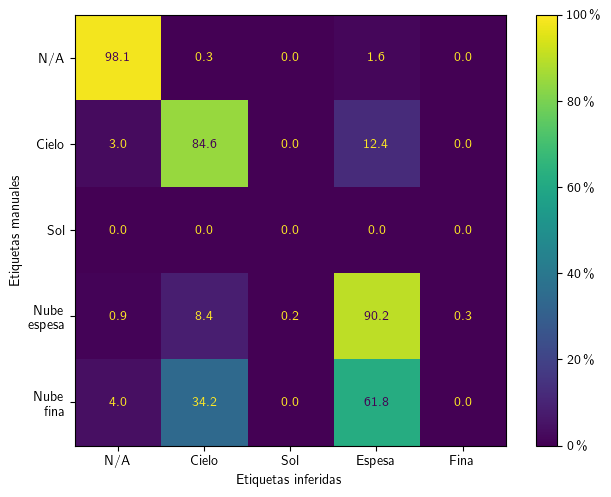

In [11]:
PlotConfusionMatrix(predictions[~isDay],ground_truth[~isDay])

### Day

<Figure size 590x400 with 0 Axes>

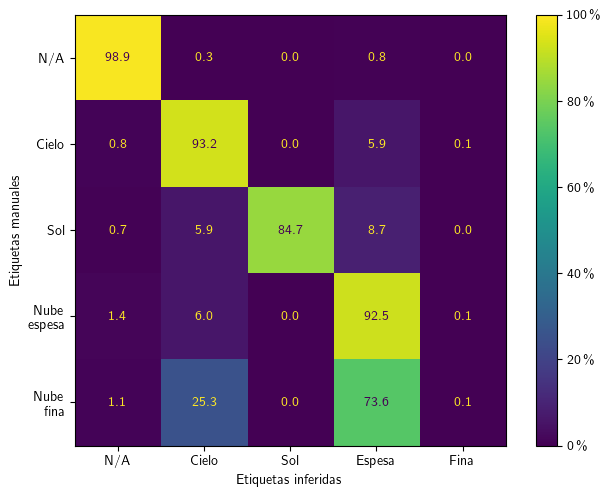

In [12]:
PlotConfusionMatrix(predictions[isDay],ground_truth[isDay])

### Sergio Sanz

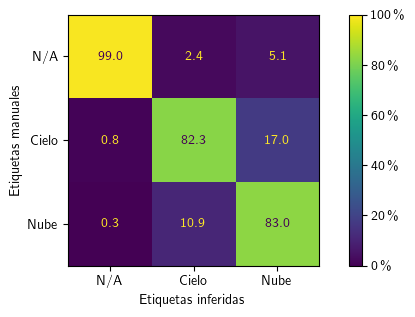

In [13]:
# Sergio Sanz
ConfusionMatrixDisplay(
    np.array([[99.0, 2.4, 5.1],
              [  .8,82.3,17.0],
              [  .3,10.9,83.0]]
            )
).plot(
    values_format='.1f',
    im_kw={
        'vmax' :100,
        'vmin' :  0,
    }
)

plt.gcf().set_size_inches(6, 3, forward=True)

ax = plt.gca()
ax.set_xlabel('Etiquetas inferidas')
ax.set_ylabel('Etiquetas manuales')
ax.set_xticks(np.arange(3),['N/A','Cielo','Nube'])
ax.set_yticks(np.arange(3),['N/A','Cielo','Nube'])

cbar = ax.images[-1].colorbar
cbar.set_ticks(
    ticks = list(range(0,101,20)),
    labels = [f"{percent} \%" for percent in range(0,101,20)],
)

plt.tight_layout(pad=.1)
plt.savefig('graficosTFG/ConfusionMatrixSergioSanz.pdf')

# Oktas

In [14]:
class Label(Enum):
    NA = 0
    Clear = 1
    Sun = 2
    Thick = 3
    Thin = 4

def cloud_cover(array_masks:np.ndarray) -> np.ndarray:
    '''
    Returns the ratio between cloud pixels and wholesky pixels
    '''

    if len(array_masks.shape) != 3:
        raise AssertionError("array mask must be an array (nimages,width,height)")
    
    total = np.prod(array_masks.shape[1:])
    total -= np.sum ( array_masks == Label.NA.value,axis=(1,2))    
    covered = np.sum( (array_masks == Label.Thick.value) + (array_masks == Label.Thin.value),axis=(1,2))

    return covered/total

def octas(array_mask:np.ndarray) -> np.int8:
    '''
    Returns the number of oktas
    '''
    return np.round(8*cloud_cover(array_mask))

In [15]:
oktas_pred = octas(predictions)
oktas_true = octas(ground_truth)

In [16]:
def PlotOktasConfusionMatrix(oktas_pred, oktas_true) -> None:
    ConfusionMatrixDisplay(
        confusion_matrix(
            y_pred=oktas_pred,
            y_true=oktas_true,
            normalize = 'true',
            labels = range(0,9)
        )*100
    ).plot(
        values_format='.1f',
        im_kw={
            'vmax' :100,
            'vmin' :  0,
        }
    )

    plt.xlabel("Octas inferidas")
    plt.ylabel("Octas de referencia")

    cbar = plt.gca().images[-1].colorbar
    cbar.set_ticks(
        ticks = list(range(0,101,20)),
        labels = [f"{percent} \%" for percent in range(0,101,20)],
    )

### All

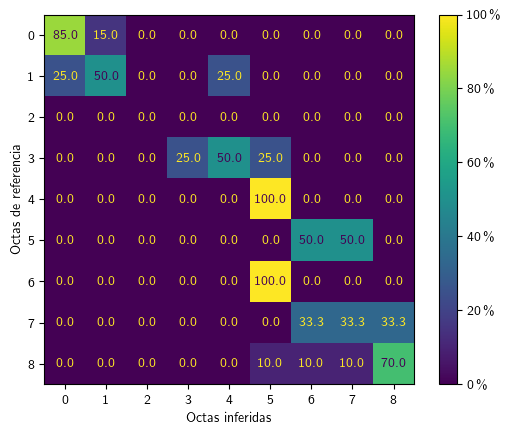

In [17]:
PlotOktasConfusionMatrix(oktas_pred=oktas_pred,oktas_true=oktas_true)

### Day

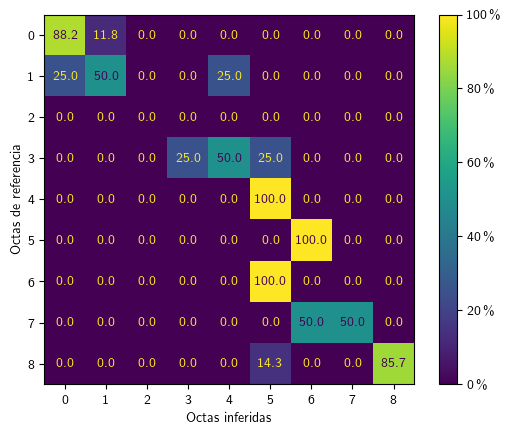

In [18]:
PlotOktasConfusionMatrix(oktas_pred=oktas_pred[isDay],oktas_true=oktas_true[isDay])

### Night

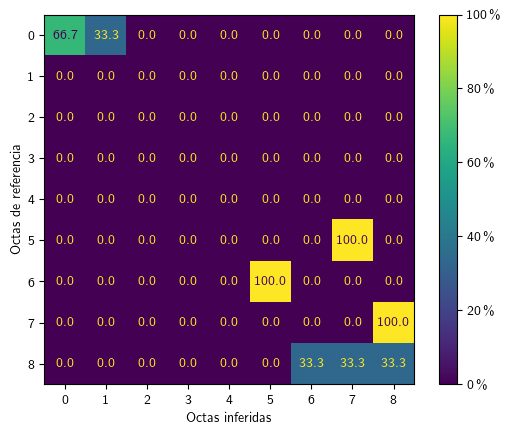

In [19]:
PlotOktasConfusionMatrix(oktas_pred=oktas_pred[~isDay],oktas_true=oktas_true[~isDay])


## Oktas error

In [20]:
oktas_error = oktas_pred-oktas_true

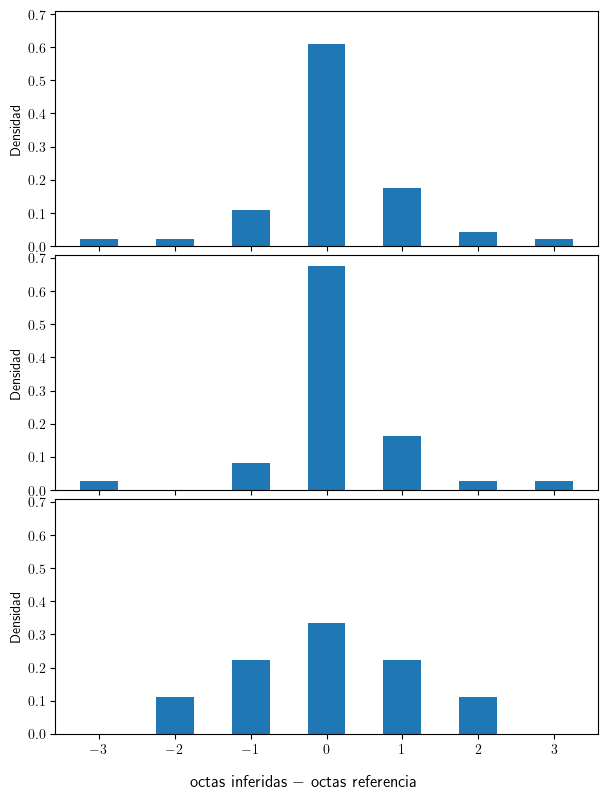

In [21]:
fig, ax = plt.subplots(3,1,sharex='all',sharey='all',figsize=(cm2inch(21-6),cm2inch(20)))

density = True
ax[0].hist(oktas_error,density=density,bins=np.arange(-4,4)+.5,rwidth=.5)
ax[1].hist(oktas_error[isDay],density=density,bins=np.arange(-4,4)+.5,rwidth=.5)
ax[2].hist(oktas_error[~isDay],density=density,bins=np.arange(-4,4)+.5,rwidth=.5)


for axes in ax:
    if density:
        axes.set_ylabel(r'Densidad')
    else:
        axes.set_ylabel(r'N$^\circ$ imágenes')

fig.supxlabel(r"octas inferidas $-$ octas referencia")

plt.tight_layout(pad=.1)
plt.subplots_adjust(bottom=.08)

plt.savefig('graficosTFG/densidades.png')

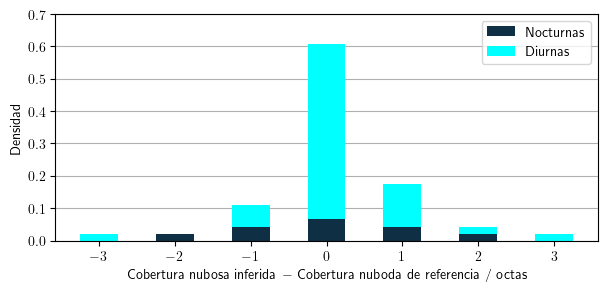

In [22]:
plt.figure(figsize=(cm2inch(21-6),cm2inch(7)))

plt.hist(
    [oktas_error[~isDay],oktas_error[isDay]],
    bins=np.arange(-3.5,4),
    rwidth=.5,
    stacked=True,
    color=['#0e2f44','#00FFFF'],
    label=["Nocturnas","Diurnas"],
    density=True
)
plt.grid(axis='y',zorder=0)
plt.gca().set_axisbelow(True)
plt.legend()

plt.xlabel(r"Cobertura nubosa inferida $-$ Cobertura nuboda de referencia / octas")
plt.ylabel(r"Densidad")

plt.yticks(np.arange(0,.8,.1))

plt.tight_layout(pad=.1)
plt.savefig('graficosTFG/hist_oktas.png')
plt.savefig('graficosTFG/hist_oktas.pdf')

In [23]:
def ErrorOktasMetrics(oktas_error:np.array) -> None:
    print(f"Mean: {oktas_error.mean():.3f}" )
    print(f"Std:  {oktas_error.std():.3f}")
    print()
    print(f"+-0 oktas { (oktas_error==0).sum()/oktas_error.size:.3%}")
    print(f"+-1 oktas { ((oktas_error==-1)+(oktas_error==0)+(oktas_error==1)).sum()/oktas_error.size:.3%}")
    print(f"+-2 oktas { ((oktas_error==-2)+(oktas_error==-1)+(oktas_error==0)+(oktas_error==1)+(oktas_error==2)).sum()/oktas_error.size:.3%}")

### All

In [24]:
ErrorOktasMetrics(oktas_error)

Mean: 0.109
Std:  0.961

+-0 oktas 60.870%
+-1 oktas 89.130%
+-2 oktas 95.652%


### Day

In [25]:
ErrorOktasMetrics(oktas_error[isDay])

Mean: 0.135
Std:  0.905

+-0 oktas 67.568%
+-1 oktas 91.892%
+-2 oktas 94.595%


### Night

In [26]:
ErrorOktasMetrics(oktas_error[~isDay])

Mean: 0.000
Std:  1.155

+-0 oktas 33.333%
+-1 oktas 77.778%
+-2 oktas 100.000%


## Cobertura de nubes

In [27]:
cloud_cover(predictions)-cloud_cover(ground_truth)

array([ 0.00291649, -0.00520905,  0.36368146,  0.10806234,  0.0079608 ,
       -0.15450362, -0.03369144,  0.03019786,  0.04375013,  0.0143898 ,
        0.02261245, -0.36303869,  0.01664068,  0.02255188,  0.14756784,
        0.00929278,  0.01064318,  0.11640501,  0.02530932, -0.09366609,
       -0.11893561,  0.01929616,  0.00793794, -0.04818201,  0.01816344,
       -0.00311944, -0.05658497,  0.00222526,  0.0028934 , -0.00153787,
        0.18181767,  0.06132515,  0.00625835,  0.02278552,  0.        ,
       -0.00612375, -0.16326334,  0.02818635, -0.00904937,  0.        ,
        0.00346722,  0.08916819, -0.04894131,  0.1925064 ,  0.07247423,
        0.03987617])

Text(0, 0.5, 'Densidad')

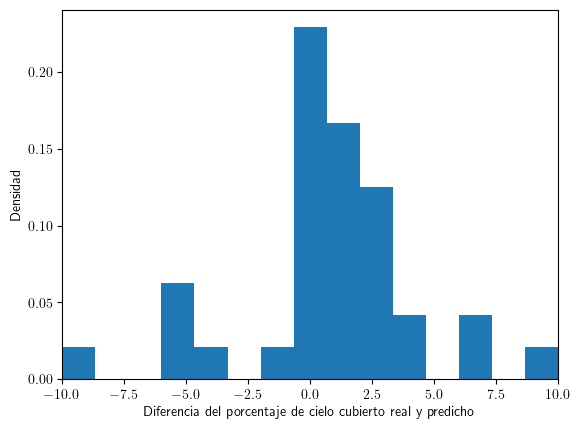

In [28]:
plt.hist( 100*(cloud_cover(predictions)-cloud_cover(ground_truth)) ,density=True,bins=15,range=[-10,10])
plt.xlim(-10,10)

plt.xlabel("Diferencia del porcentaje de cielo cubierto real y predicho")
plt.ylabel("Densidad")